### Simulation for Healthy case

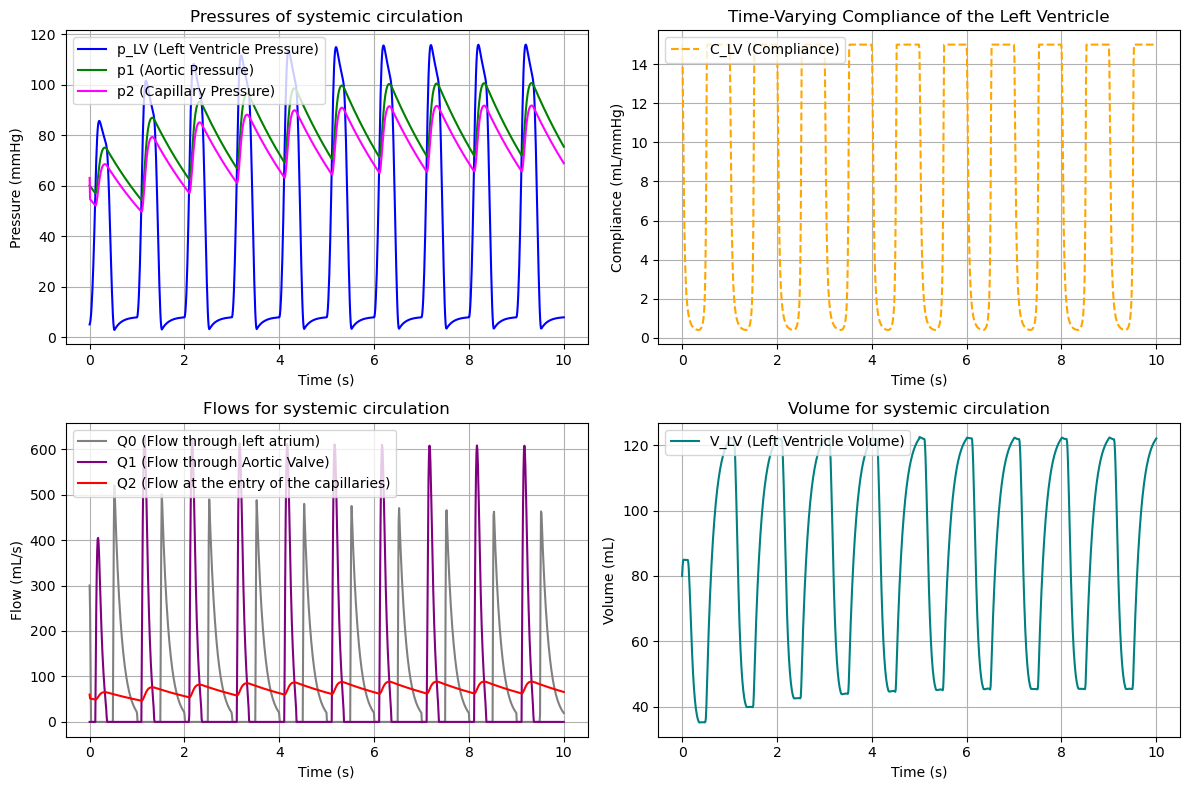

Mean Capillary Pressure: 74.63 mmHg
Mean aortic Pressure: 81.79 mmHg
Mean Flow in LA: 79.19 mL/s
Mean Flow in aortic valve: 74.66 mL/s
Mean Flow in capillaries: 71.63 mL/s


In [164]:
# Healthy
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants and Parameters: physiological case
C_max = 15  # mL/mmHg
C_min = 0.4  # mL/mmHg
R_MV = 0.01  # mmHg.s/mL
R_AV = 0.05  # mmHg.s/mL
R_h_art = 0.1  # mmHg.s/mL
R_h_cap = 1.0  # mmHg.s/mL
C_art = 2.0  # mL/mmHg
I_art = 10e-4  # mmHg.s^2/mL
p_LA = 8  # mmHg
p_RA = 3  # mmHg
T_cc = 1  # Cardiac cycle duration (70 bpm)
#p_v = 6
Vr= 5 #mL the residual blood volume

# Initial conditions physiological : diastole
p_LV0 = 5 # mmHg
p10 = 60 # mmHg
Q20 = 60  # mL/s

# Time-dependent compliance of the left ventricle
def C_LV(t):
    T_vc = 0.3 * T_cc / 0.857
    T_vr = 0.15 * T_cc /0.857
    t_mod = t % T_cc
    if t_mod <= T_vc:
        e_CC = 0.5 * (1 - np.cos(np.pi * t_mod / T_vc))
    elif t_mod <= T_vc + T_vr:
        e_CC = 0.5 * (1 + np.cos(np.pi * (t_mod - T_vc) / T_vr))
    else:
        e_CC = 0
    return 1 / ((1 / C_min - 1 / C_max) * e_CC + 1 / C_max)


def dC_LV_dt(t):
    T_vc = 0.3 * T_cc / 0.857  # Ventricular contraction phase
    T_vr = 0.15 * T_cc / 0.857  # Ventricular relaxation phase
    t_mod = t % T_cc  # Current time within the cardiac cycle

    # Smooth transition from systole to diastole and vice versa
    if t_mod <= T_vc:
        e_CC = 0.5 * (1 - np.cos(np.pi * t_mod / T_vc))
        denom_dC_dt = (((1/C_min)-(1/C_max))*e_CC+1/C_max)**2
        # Systolic phase: Compliance increases as the ventricle contracts
        num_dC_dt = -0.5*(np.pi / T_vc) * np.sin(np.pi * t_mod / T_vc) * (C_max - C_min) / (C_min*C_max)
        dC_dt=num_dC_dt/denom_dC_dt
    elif t_mod <= T_vc + T_vr:
        # Diastolic phase: Compliance decreases as the ventricle relaxes
        e_CC = 0.5 * (1 + np.cos(np.pi * (t_mod - T_vc) / T_vr))
        denom_dC_dt = (((1/C_min)-(1/C_max))*e_CC+1/C_max)**2
        num_dC_dt = 0.5*(np.pi / T_vr) * np.sin(np.pi * (t_mod - T_vc) / T_vr) * (C_max - C_min) / (C_min*C_max)
        dC_dt=num_dC_dt/denom_dC_dt
    else:
        # Post-diastolic: No change in compliance
        dC_dt = 0

    return dC_dt

# Heaviside function approximation
def H(x):
    return 0.5 * (1 + np.tanh(10 * x))

# System of ODEs
def systemic_circulation(t, y):
    p_LV, p1, Q2 = y
    C_LV_t = C_LV(t)
    
    # Equation 1: Left ventricle pressure
    dp_LV_dt = ((-p_LV * dC_LV_dt(t)) + ((p_LA - p_LV) / R_MV) * H(p_LA - p_LV) - ((p_LV - p1) / R_AV) * H(p_LV - p1)) / C_LV_t
    #dp_LV_dt = -p_LV * dC_LV_dt(t) + ((p_LA - p_LV) / R_MV) * H(p_LA - p_LV) - ((p_LV - p1) / R_AV) * H(p_LV - p1)

    # Equation 2: Capillary flow rate
    dQ2_dt = ((p1 - p_RA - ((R_h_art + R_h_cap) * Q2)) / I_art)
    
    # Equation 3: Aortic pressure
    dp1_dt = ((((p_LV - p1) / R_AV) * H(p_LV - p1) )- Q2 )/ C_art
    
    return [dp_LV_dt, dp1_dt, dQ2_dt]


# Time span
t_span = (0, 10)  # 7 seconds for one cardiac cycle (as T_cc is now 7s)
t_eval = np.linspace(*t_span, 1000)

# Solve the ODEs
#sol = solve_ivp(systemic_circulation, t_span, [p_LV0, p10, Q20], t_eval=t_eval, method="RK45")
sol = solve_ivp(systemic_circulation, t_span, [p_LV0, p10, Q20], t_eval=t_eval, method="LSODA")

C_values = [C_LV(t) for t in sol.t]

# Compute additional variables
Q1 = (sol.y[0] - sol.y[1]) / R_AV * H(sol.y[0] - sol.y[1])  # Flow through the aortic valve
C_values = np.array([C_LV(t) for t in sol.t])  # Compliance over time
V_LV = Vr + C_values * sol.y[0]  # Left ventricle volume
p2 = R_h_cap * sol.y[2] + p_RA  # Capillary pressure
Q0 = ((p_LA-sol.y[0])/R_MV)*H(p_LA-sol.y[0]) # left atrium flow

# Plot the results
plt.figure(figsize=(12, 8))

# Left Ventricle Pressure, Aortic Pressure and capillary pressure
plt.subplot(2, 2, 1)
plt.plot(sol.t, sol.y[0], label="p_LV (Left Ventricle Pressure)", color="blue")
plt.plot(sol.t, sol.y[1], label="p1 (Aortic Pressure)", color="green")
plt.plot(sol.t, p2, label="p2 (Capillary Pressure)", color="magenta")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.legend(loc="upper left")
plt.title("Pressures of systemic circulation")
plt.grid()

# Compliance Curve
plt.subplot(2, 2, 2)
plt.plot(sol.t, C_values, label="C_LV (Compliance)", linestyle="--", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Compliance (mL/mmHg)")
plt.legend(loc="upper left")
plt.title("Time-Varying Compliance of the Left Ventricle")
plt.grid()

# Flow through Aortic Valve (Q1) and capillary flow (Q2)
plt.subplot(2, 2, 3)
plt.plot(sol.t, Q0, label="Q0 (Flow through left atrium)", color="gray")
plt.plot(sol.t, Q1, label="Q1 (Flow through Aortic Valve)", color="purple")
plt.plot(sol.t, sol.y[2], label="Q2 (Flow at the entry of the capillaries)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Flow (mL/s)")
plt.legend(loc="upper left")
plt.title("Flows for systemic circulation")
plt.grid()

# Left Ventricle Volume 
plt.subplot(2, 2, 4)
plt.plot(sol.t, V_LV, label="V_LV (Left Ventricle Volume)", color="teal")
plt.xlabel("Time (s)")
plt.ylabel("Volume (mL)")
plt.legend(loc="upper left")
plt.title("Volume for systemic circulation")
plt.grid()

plt.tight_layout()
plt.show()

# Compute the mean capillary pressure using the trapezoidal rule
mean_capillary_pressure = np.trapz(p2, sol.t) / (sol.t[-1] - sol.t[0])
print(f"Mean Capillary Pressure: {mean_capillary_pressure:.2f} mmHg")
mean_aortic_pressure = np.trapz(sol.y[1], sol.t) / (sol.t[-1] - sol.t[0])
print(f"Mean aortic Pressure: {mean_aortic_pressure:.2f} mmHg")

mean_flow_Q0 = np.trapz(Q0, sol.t) / (sol.t[-1] - sol.t[0])
print(f"Mean Flow in LA: {mean_flow_Q0:.2f} mL/s")
mean_flow_Q1 = np.trapz(Q1, sol.t) / (sol.t[-1] - sol.t[0])
print(f"Mean Flow in aortic valve: {mean_flow_Q1:.2f} mL/s")
mean_flow_Q2 = np.trapz(sol.y[2], sol.t) / (sol.t[-1] - sol.t[0])
print(f"Mean Flow in capillaries: {mean_flow_Q2:.2f} mL/s")

## Simulation of Aortic Stenosis (moderate and severe)

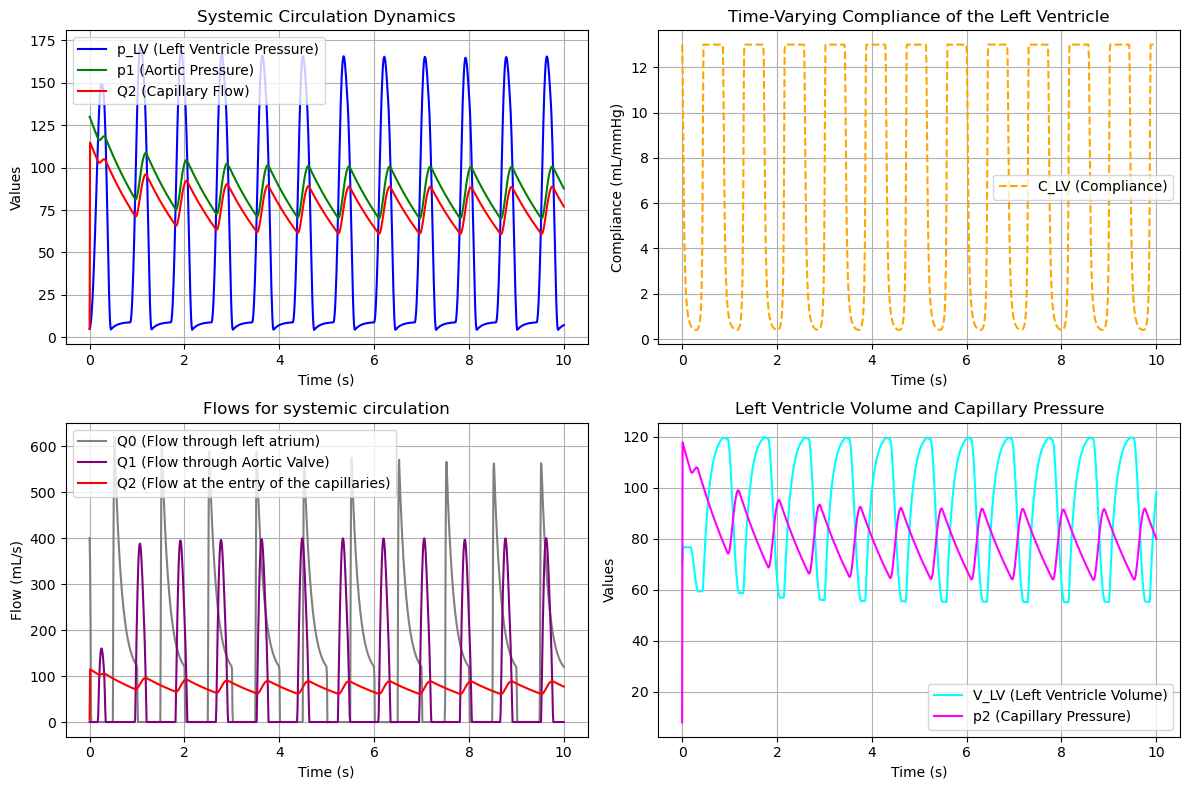

Mean Flow in LA: 130.65 mL/s
Mean Flow in aortic valve: 71.27 mL/s
Mean Flow in capillaries: 77.64 mL/s
Mean Capillary Pressure: 80.64 mmHg
Mean aortic Pressure: 88.46 mmHg


In [163]:
# Pathological case: moderate
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

C_max = 13  # mL/mmHg
C_min = 0.4  # mL/mmHg
R_MV = 0.01  # mmHg.s/mL
R_AV = 0.2  # mmHg.s/mL
R_h_art = 0.1  # mmHg.s/mL
R_h_cap = 1.0  # mmHg.s/mL
C_art = 1.5  # mL/mmHg
I_art = 10e-4  # mmHg.s^2/mL
p_LA = 9  # mmHg
p_RA = 3  # mmHg
T_cc = 6/7  # Cardiac cycle duration (70 bpm)
Vr = 5
# Time-dependent compliance of the left ventricle
def C_LV(t):
    T_vc = 0.3 * T_cc / 0.857
    T_vr = 0.15 * T_cc /0.857
    t_mod = t % T_cc
    if t_mod <= T_vc:
        e_CC = 0.5 * (1 - np.cos(np.pi * t_mod / T_vc))
    elif t_mod <= T_vc + T_vr:
        e_CC = 0.5 * (1 + np.cos(np.pi * (t_mod - T_vc) / T_vr))
    else:
        e_CC = 0
    return 1 / ((1 / C_min - 1 / C_max) * e_CC + 1 / C_max)


def dC_LV_dt(t):
    T_vc = 0.3 * T_cc / 0.857  # Ventricular contraction phase
    T_vr = 0.15 * T_cc / 0.857  # Ventricular relaxation phase
    t_mod = t % T_cc  # Current time within the cardiac cycle

    # Smooth transition from systole to diastole and vice versa
    if t_mod <= T_vc:
        e_CC = 0.5 * (1 - np.cos(np.pi * t_mod / T_vc))
        denom_dC_dt = (((1/C_min)-(1/C_max))*e_CC+1/C_max)**2
        # Systolic phase: Compliance increases as the ventricle contracts
        num_dC_dt = -0.5*(np.pi / T_vc) * np.sin(np.pi * t_mod / T_vc) * (C_max - C_min) / (C_min*C_max)
        dC_dt=num_dC_dt/denom_dC_dt
    elif t_mod <= T_vc + T_vr:
        # Diastolic phase: Compliance decreases as the ventricle relaxes
        e_CC = 0.5 * (1 + np.cos(np.pi * (t_mod - T_vc) / T_vr))
        denom_dC_dt = (((1/C_min)-(1/C_max))*e_CC+1/C_max)**2
        num_dC_dt = 0.5*(np.pi / T_vr) * np.sin(np.pi * (t_mod - T_vc) / T_vr) * (C_max - C_min) / (C_min*C_max)
        dC_dt=num_dC_dt/denom_dC_dt
    else:
        # Post-diastolic: No change in compliance
        dC_dt = 0

    return dC_dt

# Heaviside function approximation
def H(x):
    return 0.5 * (1 + np.tanh(10 * x))

# System of ODEs
def systemic_circulation(t, y):
    p_LV, p1, Q2 = y
    C_LV_t = C_LV(t)
    
    # Equation 1: Left ventricle pressure
    dp_LV_dt = ((-p_LV * dC_LV_dt(t)) + ((p_LA - p_LV) / R_MV) * H(p_LA - p_LV) - ((p_LV - p1) / R_AV) * H(p_LV - p1)) / C_LV_t
    #dp_LV_dt = -p_LV * dC_LV_dt(t) + ((p_LA - p_LV) / R_MV) * H(p_LA - p_LV) - ((p_LV - p1) / R_AV) * H(p_LV - p1)

    # Equation 2: Capillary flow rate
    dQ2_dt = ((p1 - p_RA - ((R_h_art + R_h_cap) * Q2)) / I_art)
    
    # Equation 3: Aortic pressure
    dp1_dt = ((((p_LV - p1) / R_AV) * H(p_LV - p1) )- Q2 )/ C_art
    
    return [dp_LV_dt, dp1_dt, dQ2_dt]


# Initial conditions phatological
p_LV0 = 5  # mmHg
p10 = 130  # mmHg
Q20 = 5  # mL/s

# Time span
t_span = (0, 10)  # 7 seconds for one cardiac cycle (as T_cc is now 7s)
t_eval = np.linspace(*t_span, 1000)

# Solve the ODEs
#sol = solve_ivp(systemic_circulation, t_span, [p_LV0, p10, Q20], t_eval=t_eval, method="RK45")
sol_p = solve_ivp(systemic_circulation, t_span, [p_LV0, p10, Q20], t_eval=t_eval, method="LSODA")

C_values = [C_LV(t) for t in sol.t]

# Compute additional variables
Q1_p = (sol_p.y[0] - sol_p.y[1]) / R_AV * H(sol_p.y[0] - sol_p.y[1])  # Flow through the aortic valve
C_values = np.array([C_LV(t) for t in sol_p.t])  # Compliance over time
V_LV_p = Vr + C_values * sol_p.y[0]  # Left ventricle volume
p2_p = R_h_cap * sol_p.y[2] + p_RA  # Capillary pressure
Q0_p = ((p_LA-sol.y[0])/R_MV)*H(p_LA-sol.y[0]) # left atrium flow
# Plot the results
plt.figure(figsize=(12, 8))

# Left Ventricle Pressure, Aortic Pressure, and Flow
plt.subplot(2, 2, 1)
plt.plot(sol_p.t, sol_p.y[0], label="p_LV (Left Ventricle Pressure)", color="blue")
plt.plot(sol_p.t, sol_p.y[1], label="p1 (Aortic Pressure)", color="green")
plt.plot(sol_p.t, sol_p.y[2], label="Q2 (Capillary Flow)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Values")
plt.legend()
plt.title("Systemic Circulation Dynamics")
plt.grid()

# Compliance Curve
plt.subplot(2, 2, 2)
plt.plot(sol_p.t, C_values, label="C_LV (Compliance)", linestyle="--", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Compliance (mL/mmHg)")
plt.legend()
plt.title("Time-Varying Compliance of the Left Ventricle")
plt.grid()

# Flow through Aortic Valve (Q1)
plt.subplot(2, 2, 3)
plt.plot(sol_p.t, Q0_p, label="Q0 (Flow through left atrium)", color="gray")
plt.plot(sol_p.t, Q1_p, label="Q1 (Flow through Aortic Valve)", color="purple")
plt.plot(sol_p.t, sol_p.y[2], label="Q2 (Flow at the entry of the capillaries)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Flow (mL/s)")
plt.legend(loc="upper left")
plt.title("Flows for systemic circulation")
plt.grid()

# Left Ventricle Volume and Capillary Pressure
plt.subplot(2, 2, 4)
plt.plot(sol_p.t, V_LV_p, label="V_LV (Left Ventricle Volume)", color="cyan")
plt.plot(sol_p.t, p2_p, label="p2 (Capillary Pressure)", color="magenta")
plt.xlabel("Time (s)")
plt.ylabel("Values")
plt.legend()
plt.title("Left Ventricle Volume and Capillary Pressure")
plt.grid()

plt.tight_layout()
plt.show()

mean_flow_Q0 = np.trapz(Q0_p, sol_p.t) / (sol_p.t[-1] - sol_p.t[0])
print(f"Mean Flow in LA: {mean_flow_Q0:.2f} mL/s")
mean_flow_Q1 = np.trapz(Q1_p, sol_p.t) / (sol_p.t[-1] - sol_p.t[0])
print(f"Mean Flow in aortic valve: {mean_flow_Q1:.2f} mL/s")
mean_flow_Q2 = np.trapz(sol_p.y[2], sol_p.t) / (sol_p.t[-1] - sol_p.t[0])
print(f"Mean Flow in capillaries: {mean_flow_Q2:.2f} mL/s")

mean_capillary_pressure = np.trapz(p2_p, sol_p.t) / (sol_p.t[-1] - sol_p.t[0])
print(f"Mean Capillary Pressure: {mean_capillary_pressure:.2f} mmHg")
mean_aortic_pressure = np.trapz(sol_p.y[1], sol_p.t) / (sol_p.t[-1] - sol_p.t[0])
print(f"Mean aortic Pressure: {mean_aortic_pressure:.2f} mmHg")

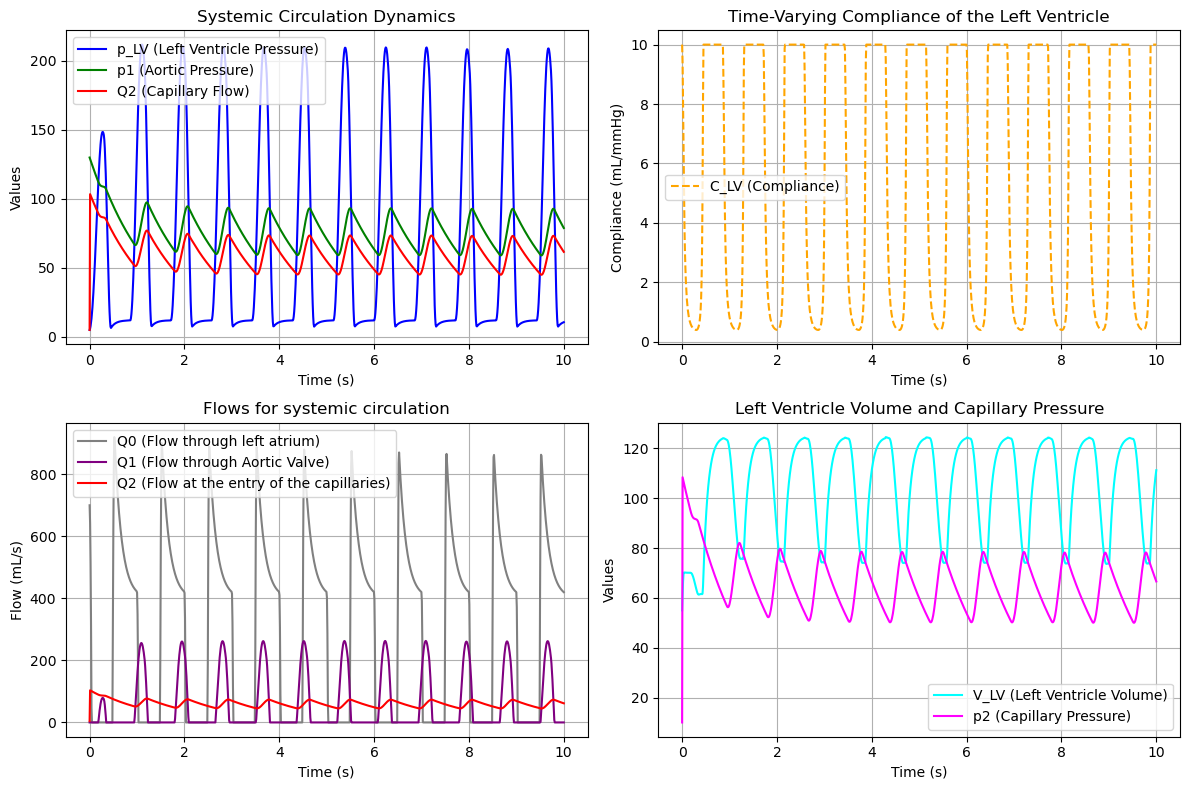

Mean Flow in LA: 290.12 mL/s
Mean Flow in aortic valve: 55.61 mL/s
Mean Flow in capillaries: 60.70 mL/s
Mean Capillary Pressure: 65.70 mmHg
Mean aortic Pressure: 77.89 mmHg


In [162]:
# Pathological case : severe 
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# # Constants and Parameters: physiological case
#C_max = 15  # mL/mmHg
#C_min = 0.4  # mL/mmHg
#R_MV = 0.01  # mmHg.s/mL
#R_AV = 0.8  # mmHg.s/mL
#R_h_art = 0.1  # mmHg.s/mL
#R_h_cap = 1.0  # mmHg.s/mL
#C_art = 2.0  # mL/mmHg
#I_art = 10e-4  # mmHg.s^2/mL
#p_LA = 8  # mmHg
#p_RA = 3  # mmHg
#T_cc = 1  # Cardiac cycle duration (70 bpm)
#p_v = 6
#Vr= 5 #mL the residual blood volume

C_max = 10  # mL/mmHg
C_min = 0.4  # mL/mmHg
R_MV = 0.01  # mmHg.s/mL
R_AV = 0.5  # mmHg.s/mL
R_h_art = 0.2  # mmHg.s/mL
R_h_cap = 1.0  # mmHg.s/mL
C_art = 1.0  # mL/mmHg
I_art = 10e-4  # mmHg.s^2/mL
p_LA = 12  # mmHg
p_RA = 5  # mmHg
T_cc = 6/7  # Cardiac cycle duration (70 bpm)
Vr = 5
# Time-dependent compliance of the left ventricle
def C_LV(t):
    T_vc = 0.3 * T_cc / 0.857
    T_vr = 0.15 * T_cc /0.857
    t_mod = t % T_cc
    if t_mod <= T_vc:
        e_CC = 0.5 * (1 - np.cos(np.pi * t_mod / T_vc))
    elif t_mod <= T_vc + T_vr:
        e_CC = 0.5 * (1 + np.cos(np.pi * (t_mod - T_vc) / T_vr))
    else:
        e_CC = 0
    return 1 / ((1 / C_min - 1 / C_max) * e_CC + 1 / C_max)


def dC_LV_dt(t):
    T_vc = 0.3 * T_cc / 0.857  # Ventricular contraction phase
    T_vr = 0.15 * T_cc / 0.857  # Ventricular relaxation phase
    t_mod = t % T_cc  # Current time within the cardiac cycle

    # Smooth transition from systole to diastole and vice versa
    if t_mod <= T_vc:
        e_CC = 0.5 * (1 - np.cos(np.pi * t_mod / T_vc))
        denom_dC_dt = (((1/C_min)-(1/C_max))*e_CC+1/C_max)**2
        # Systolic phase: Compliance increases as the ventricle contracts
        num_dC_dt = -0.5*(np.pi / T_vc) * np.sin(np.pi * t_mod / T_vc) * (C_max - C_min) / (C_min*C_max)
        dC_dt=num_dC_dt/denom_dC_dt
    elif t_mod <= T_vc + T_vr:
        # Diastolic phase: Compliance decreases as the ventricle relaxes
        e_CC = 0.5 * (1 + np.cos(np.pi * (t_mod - T_vc) / T_vr))
        denom_dC_dt = (((1/C_min)-(1/C_max))*e_CC+1/C_max)**2
        num_dC_dt = 0.5*(np.pi / T_vr) * np.sin(np.pi * (t_mod - T_vc) / T_vr) * (C_max - C_min) / (C_min*C_max)
        dC_dt=num_dC_dt/denom_dC_dt
    else:
        # Post-diastolic: No change in compliance
        dC_dt = 0

    return dC_dt

# Heaviside function approximation
def H(x):
    return 0.5 * (1 + np.tanh(10 * x))

# System of ODEs
def systemic_circulation(t, y):
    p_LV, p1, Q2 = y
    C_LV_t = C_LV(t)
    
    # Equation 1: Left ventricle pressure
    dp_LV_dt = ((-p_LV * dC_LV_dt(t)) + ((p_LA - p_LV) / R_MV) * H(p_LA - p_LV) - ((p_LV - p1) / R_AV) * H(p_LV - p1)) / C_LV_t
    #dp_LV_dt = -p_LV * dC_LV_dt(t) + ((p_LA - p_LV) / R_MV) * H(p_LA - p_LV) - ((p_LV - p1) / R_AV) * H(p_LV - p1)

    # Equation 2: Capillary flow rate
    dQ2_dt = ((p1 - p_RA - ((R_h_art + R_h_cap) * Q2)) / I_art)
    
    # Equation 3: Aortic pressure
    dp1_dt = ((((p_LV - p1) / R_AV) * H(p_LV - p1) )- Q2 )/ C_art
    
    return [dp_LV_dt, dp1_dt, dQ2_dt]

# # Initial conditions physiological 
# p_LV0 = 5 # mmHg
# p10 = 80 # mmHg
# Q20 = 70  # mL/s

# Initial conditions phatological
p_LV0 = 5  # mmHg
p10 = 130  # mmHg
Q20 = 5  # mL/s

# Time span
t_span = (0, 10)  # 7 seconds for one cardiac cycle (as T_cc is now 7s)
t_eval = np.linspace(*t_span, 1000)

# Solve the ODEs
#sol = solve_ivp(systemic_circulation, t_span, [p_LV0, p10, Q20], t_eval=t_eval, method="RK45")
sol_ps = solve_ivp(systemic_circulation, t_span, [p_LV0, p10, Q20], t_eval=t_eval, method="LSODA")

C_values = [C_LV(t) for t in sol.t]

# Compute additional variables
Q1_ps = (sol_ps.y[0] - sol_ps.y[1]) / R_AV * H(sol_ps.y[0] - sol_ps.y[1])  # Flow through the aortic valve
C_values = np.array([C_LV(t) for t in sol_ps.t])  # Compliance over time
V_LV_ps = Vr + C_values * sol_ps.y[0]  # Left ventricle volume
p2_ps = R_h_cap * sol_ps.y[2] + p_RA  # Capillary pressure
Q0_ps = ((p_LA-sol.y[0])/R_MV)*H(p_LA-sol.y[0]) # left atrium flow

# Plot the results
plt.figure(figsize=(12, 8))

# Left Ventricle Pressure, Aortic Pressure, and Flow
plt.subplot(2, 2, 1)
plt.plot(sol_ps.t, sol_ps.y[0], label="p_LV (Left Ventricle Pressure)", color="blue")
plt.plot(sol_ps.t, sol_ps.y[1], label="p1 (Aortic Pressure)", color="green")
plt.plot(sol_ps.t, sol_ps.y[2], label="Q2 (Capillary Flow)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Values")
plt.legend()
plt.title("Systemic Circulation Dynamics")
plt.grid()

# Compliance Curve
plt.subplot(2, 2, 2)
plt.plot(sol_ps.t, C_values, label="C_LV (Compliance)", linestyle="--", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Compliance (mL/mmHg)")
plt.legend()
plt.title("Time-Varying Compliance of the Left Ventricle")
plt.grid()

# Flow through Aortic Valve (Q1)
plt.subplot(2, 2, 3)
plt.plot(sol_ps.t, Q0_ps, label="Q0 (Flow through left atrium)", color="gray")
plt.plot(sol_ps.t, Q1_ps, label="Q1 (Flow through Aortic Valve)", color="purple")
plt.plot(sol_ps.t, sol_ps.y[2], label="Q2 (Flow at the entry of the capillaries)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Flow (mL/s)")
plt.legend(loc="upper left")
plt.title("Flows for systemic circulation")
plt.grid()


# Left Ventricle Volume and Capillary Pressure
plt.subplot(2, 2, 4)
plt.plot(sol_ps.t, V_LV_ps, label="V_LV (Left Ventricle Volume)", color="cyan")
plt.plot(sol_ps.t, p2_ps, label="p2 (Capillary Pressure)", color="magenta")
plt.xlabel("Time (s)")
plt.ylabel("Values")
plt.legend()
plt.title("Left Ventricle Volume and Capillary Pressure")
plt.grid()

plt.tight_layout()
plt.show()

mean_flow_Q0 = np.trapz(Q0_ps, sol_ps.t) / (sol_ps.t[-1] - sol_ps.t[0])
print(f"Mean Flow in LA: {mean_flow_Q0:.2f} mL/s")
mean_flow_Q1 = np.trapz(Q1_ps, sol_ps.t) / (sol_ps.t[-1] - sol_ps.t[0])
print(f"Mean Flow in aortic valve: {mean_flow_Q1:.2f} mL/s")
mean_flow_Q2 = np.trapz(sol_ps.y[2], sol_ps.t) / (sol_ps.t[-1] - sol_ps.t[0])
print(f"Mean Flow in capillaries: {mean_flow_Q2:.2f} mL/s")

mean_capillary_pressure = np.trapz(p2_ps, sol_ps.t) / (sol_ps.t[-1] - sol_ps.t[0])
print(f"Mean Capillary Pressure: {mean_capillary_pressure:.2f} mmHg")
mean_aortic_pressure = np.trapz(sol_ps.y[1], sol_ps.t) / (sol_ps.t[-1] - sol_ps.t[0])
print(f"Mean aortic Pressure: {mean_aortic_pressure:.2f} mmHg")

## Plots of comparison for report 

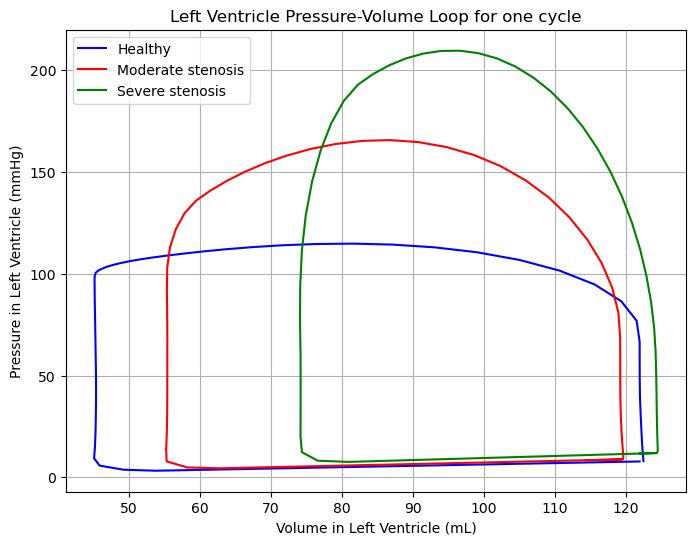

In [161]:
# plots of PV loops
desired_cycle = 6
cycle_start_time = (desired_cycle - 1) * T_cc
cycle_end_time = desired_cycle * T_cc

#one cycle
one_cycle_mask_healthy = (sol.t >= cycle_start_time) & (sol.t < cycle_end_time)
t_one_cycle_healthy = sol.t[one_cycle_mask_healthy]
p_LV_one_cycle_healthy = sol.y[0][one_cycle_mask_healthy]
V_LV_one_cycle_healthy = V_LV[one_cycle_mask_healthy]

#[V_LV for t, p_LV in zip(t_one_cycle_healthy, p_LV_one_cycle_healthy)]

one_cycle_mask_pathology = (sol_p.t >= cycle_start_time) & (sol_p.t < cycle_end_time)
t_one_cycle_pathology = sol_p.t[one_cycle_mask_pathology]
p_LV_one_cycle_pathology = sol_p.y[0][one_cycle_mask_pathology]
V_LV_one_cycle_pathology = V_LV_p[one_cycle_mask_healthy]
p_LV_one_cycle_pathology_s = sol_ps.y[0][one_cycle_mask_pathology]
V_LV_one_cycle_pathology_s = V_LV_ps[one_cycle_mask_healthy]


# Plot the pressure-volume loops
plt.figure(figsize=(8, 6))
plt.plot(V_LV_one_cycle_healthy, p_LV_one_cycle_healthy, label=f"Healthy", color="blue")
plt.plot(V_LV_one_cycle_pathology, p_LV_one_cycle_pathology, label=f"Moderate stenosis", color="red")
plt.plot(V_LV_one_cycle_pathology_s, p_LV_one_cycle_pathology_s, label=f"Severe stenosis", color="green")
plt.xlabel("Volume in Left Ventricle (mL)")
plt.ylabel("Pressure in Left Ventricle (mmHg)")
plt.title(f"Left Ventricle Pressure-Volume Loop for one cycle")
plt.grid()
plt.legend()
plt.show()


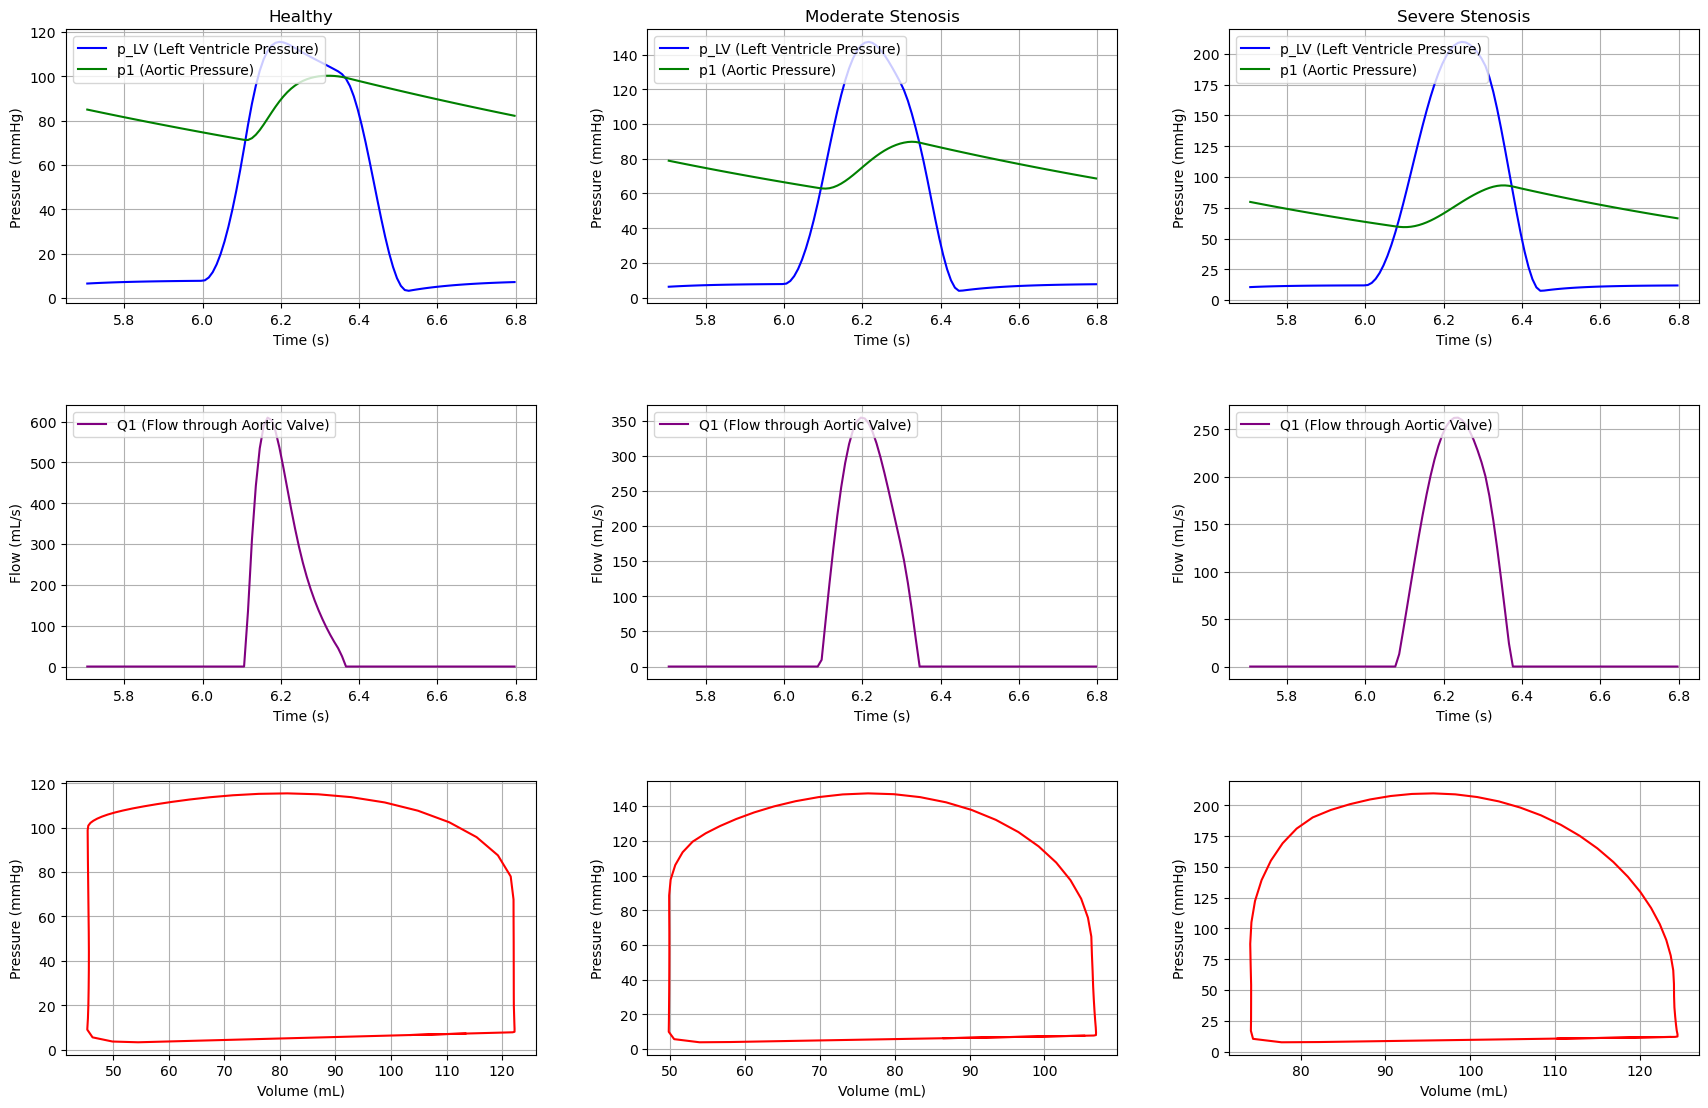

In [138]:
# Plot final the results

plt.figure(figsize=(18, 12))  # Increase figure size for better visibility

# Healthy (first category)
# 1. Left Ventricle Pressure and Aortic Pressure vs Time (Healthy)
plt.subplot(3, 3, 1)
start_idx = 570  # Start of the cycle
end_idx = 680    # End of the cycle
plt.plot(sol.t[start_idx:end_idx], sol.y[0][start_idx:end_idx], label="p_LV (Left Ventricle Pressure)", color="blue")
plt.plot(sol.t[start_idx:end_idx], sol.y[1][start_idx:end_idx], label="p1 (Aortic Pressure)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.legend(loc="upper left")
plt.grid()
plt.title("Healthy")

# 2. Flow through Aortic Valve (Q1) (Healthy)
plt.subplot(3, 3, 4)
plt.plot(sol.t[start_idx:end_idx], Q1[start_idx:end_idx], label="Q1 (Flow through Aortic Valve)", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("Flow (mL/s)")
plt.legend(loc="upper left")
plt.grid()

# 3. Pressure-Volume Loop for Left Ventricle (Healthy)
plt.subplot(3, 3, 7)
plt.plot(V_LV[start_idx:end_idx], sol.y[0][start_idx:end_idx], label="Pressure-Volume Loop", color="red")
plt.xlabel("Volume (mL)")
plt.ylabel("Pressure (mmHg)")
plt.grid()

# Moderate Stenosis (second category)
# 4. Left Ventricle Pressure and Aortic Pressure vs Time (Moderate Stenosis)
plt.subplot(3, 3, 2)
plt.plot(sol_p.t[start_idx:end_idx], sol_p.y[0][start_idx:end_idx], label="p_LV (Left Ventricle Pressure)", color="blue")
plt.plot(sol_p.t[start_idx:end_idx], sol_p.y[1][start_idx:end_idx], label="p1 (Aortic Pressure)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.legend(loc="upper left")
plt.grid()
plt.title("Moderate Stenosis")

# 5. Flow through Aortic Valve (Q1) (Moderate Stenosis)
plt.subplot(3, 3, 5)
plt.plot(sol_p.t[start_idx:end_idx], Q1_p[start_idx:end_idx], label="Q1 (Flow through Aortic Valve)", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("Flow (mL/s)")
plt.legend(loc="upper left")
plt.grid()

# 6. Pressure-Volume Loop for Left Ventricle (Moderate Stenosis)
plt.subplot(3, 3, 8)
plt.plot(V_LV_p[start_idx:end_idx], sol_p.y[0][start_idx:end_idx], label="Pressure-Volume Loop", color="red")
plt.xlabel("Volume (mL)")
plt.ylabel("Pressure (mmHg)")
plt.grid()

# Severe Stenosis (third category)
# 7. Left Ventricle Pressure and Aortic Pressure vs Time (Severe Stenosis)
plt.subplot(3, 3, 3)
plt.plot(sol_ps.t[start_idx:end_idx], sol_ps.y[0][start_idx:end_idx], label="p_LV (Left Ventricle Pressure)", color="blue")
plt.plot(sol_ps.t[start_idx:end_idx], sol_ps.y[1][start_idx:end_idx], label="p1 (Aortic Pressure)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.legend(loc="upper left")
plt.grid()
plt.title("Severe Stenosis")

# 8. Flow through Aortic Valve (Q1) (Severe Stenosis)
plt.subplot(3, 3, 6)
plt.plot(sol_ps.t[start_idx:end_idx], Q1_ps[start_idx:end_idx], label="Q1 (Flow through Aortic Valve)", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("Flow (mL/s)")
plt.legend(loc="upper left")
plt.grid()

# 9. Pressure-Volume Loop for Left Ventricle (Severe Stenosis)
plt.subplot(3, 3, 9)
plt.plot(V_LV_ps[start_idx:end_idx], sol_ps.y[0][start_idx:end_idx], label="Pressure-Volume Loop", color="red")
plt.xlabel("Volume (mL)")
plt.ylabel("Pressure (mmHg)")
plt.grid()

# Adjust layout for better spacing
plt.tight_layout(pad=4.0)  # Increase the padding between subplots
plt.show()


In [ ]:
# Varying parameters for Identifiability

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

T_cc = 1

def system(t, y, Q1_func, p2_func, I_art, R, C_art):
    Q2, p1 = y
    # Evaluate Q1 and p2 at the current time step t
    Q1 = Q1_func(t)
    p2 = p2_func(t)
    
    #Capillary flow rate
    dQ2_dt = (p1 - p2 - (R * Q2)) / I_art
    
    #Aortic pressure
    dp1_dt = (Q1 - Q2) / C_art
    return [dQ2_dt, dp1_dt]

def Q1_func(t):
    return 500*(np.sin((np.pi*t/T_cc))**2)

def p2_func(t):
    return 80 + 10 * np.sin(2 * np.pi * t / T_cc)

t_span = (0, 10)  
t_eval = np.linspace(*t_span, 1000)

# Initial conditions
Q2_0 = 200  
p1_0 = 200  

# Parameter ranges
I_art_values = [0.05, 0.1, 0.2, 0.3, 0.4] 
R_values = [0.5, 1.0, 1.5, 2.0, 2.5]      
C_art_values = [1.0, 1.5, 2.0, 2.5, 3.0]  


fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

for I_art in I_art_values:
    sol = solve_ivp(
        system,
        t_span,
        [Q2_0, p1_0],
        t_eval=t_eval,
        args=(Q1_func, p2_func, I_art, R_values[0], C_art_values[0]),
    )
    Q2 = sol.y[0]
    axs[0, 0].plot(t_eval, Q2, label=f"I_art={I_art}")

axs[0, 0].set_title("Q2 vs Time for varying I_art")
axs[0, 0].set_ylabel("Q2 (Flow rate)")
axs[0, 0].legend()
axs[0, 0].grid()

for R in R_values:
    sol = solve_ivp(
        system,
        t_span,
        [Q2_0, p1_0],
        t_eval=t_eval,
        args=(Q1_func, p2_func, I_art_values[0], R, C_art_values[0]),
    )
    Q2 = sol.y[0]
    axs[1, 0].plot(t_eval, Q2, label=f"R={R}")

axs[1, 0].set_title("Q2 vs Time for varying R")
axs[1, 0].set_ylabel("Q2 (Flow rate)")
axs[1, 0].legend()
axs[1, 0].grid()

for C_art in C_art_values:
    sol = solve_ivp(
        system,
        t_span,
        [Q2_0, p1_0],
        t_eval=t_eval,
        args=(Q1_func, p2_func, I_art_values[0], R_values[0], C_art),
    )
    Q2 = sol.y[0]
    axs[2, 0].plot(t_eval, Q2, label=f"C_art={C_art}")

axs[2, 0].set_title("Q2 vs Time for varying C_art")
axs[2, 0].set_xlabel("Time (s)")
axs[2, 0].set_ylabel("Q2 (Flow rate)")
axs[2, 0].legend()
axs[2, 0].grid()

for I_art in I_art_values:
    sol = solve_ivp(
        system,
        t_span,
        [Q2_0, p1_0],
        t_eval=t_eval,
        args=(Q1_func, p2_func, I_art, R_values[0], C_art_values[0]),
    )
    p1 = sol.y[1]
    axs[0, 1].plot(t_eval, p1, label=f"I_art={I_art}")

axs[0, 1].set_title("p1 vs Time for varying I_art")
axs[0, 1].set_ylabel("p1 (Aortic pressure)")
axs[0, 1].legend()
axs[0, 1].grid()

for R in R_values:
    sol = solve_ivp(
        system,
        t_span,
        [Q2_0, p1_0],
        t_eval=t_eval,
        args=(Q1_func, p2_func, I_art_values[0], R, C_art_values[0]),
    )
    p1 = sol.y[1]
    axs[1, 1].plot(t_eval, p1, label=f"R={R}")

axs[1, 1].set_title("p1 vs Time for varying R")
axs[1, 1].set_ylabel("p1 (Aortic pressure)")
axs[1, 1].legend()
axs[1, 1].grid()

for C_art in C_art_values:
    sol = solve_ivp(
        system,
        t_span,
        [Q2_0, p1_0],
        t_eval=t_eval,
        args=(Q1_func, p2_func, I_art_values[0], R_values[0], C_art),
    )
    p1 = sol.y[1]
    axs[2, 1].plot(t_eval, p1, label=f"C_art={C_art}")

axs[2, 1].set_title("p1 vs Time for varying C_art")
axs[2, 1].set_xlabel("Time (s)")
axs[2, 1].set_ylabel("p1 (Aortic pressure)")
axs[2, 1].legend()
axs[2, 1].grid()

plt.suptitle("Impact of Parameters on Q2 and p1", fontsize=16)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.legend(loc="upper left")
plt.show()
